# Генерируем новые признаки с помощью VGG16. Также - создаем модель для обучения с весами от VGG16. В этой версии без создания промежуточных файлов

In [0]:
%matplotlib inline
import cv2
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.preprocessing import OneHotEncoder

import scipy
import tqdm

In [0]:
#Mountig G drive
from glob import glob
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Copy & extract files
!mkdir ./data
!cp '/content/drive/My Drive/fish/boxes.zip' ./data
!cp '/content/drive/My Drive/fish/train.zip' ./data
!cp '/content/drive/My Drive/fish/test_stg1.zip' ./data
!unzip -n ./data/boxes.zip > /dev/null
!unzip -n ./data/train.zip > /dev/null
!unzip -n ./data/test_stg1.zip > /dev/null

!ls -al

total 72
drwxr-xr-x  1 root root  4096 Jun  1 19:23 .
drwxr-xr-x  1 root root  4096 Jun  1 19:21 ..
drwxr-xr-x  2 root root  4096 May 20 22:32 boxes
drwxr-xr-x  1 root root  4096 May 29 18:19 .config
drwxr-xr-x  2 root root  4096 Jun  1 19:23 data
drwx------  4 root root  4096 Jun  1 19:22 drive
drwxrwxr-x  3 root root  4096 Nov 10  2016 __MACOSX
drwxr-xr-x  1 root root  4096 May 29 18:19 sample_data
drwxr-xr-x  2 root root 36864 Nov 10  2016 test_stg1
drwxr-xr-x 10 root root  4096 Nov  9  2016 train


In [0]:
#Loading VGG16 model
IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = keras.applications.vgg16.VGG16(include_top=False,
                                          weights='imagenet',
                                          input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


58892288/58889256 [==============================] - 2s 0us/step


In [0]:
NUM_FEATURES = 7 #Number of fish classes - NEED TO MAKE DYNAMIC!
#adding final layer and freezing first layers
feature_tensor = features.layers[-1].output

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

output = keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output = keras.layers.Conv2D( NUM_FEATURES+4,
                             kernel_size=(1, 1), 
                             activation='linear',
                             kernel_regularizer='l2')(output)

train_model = keras.models.Model(inputs=features.inputs, outputs=output, name='trainable_model')
train_model.summary()

Model: "trainable_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 750, 1200, 3)]    0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 750, 1200, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 750, 1200, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 375, 600, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 375, 600, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 375, 600, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 187, 300, 128) 

# Загружаем разметку

In [0]:
#Get labels from train dir
labels = []
for path in glob('./train/*'):
    cur_label = path.split('/')[-1].lower()
    if cur_label == 'nof':
        continue
    labels.append(path.split('/')[-1].lower())

#Number of classes to use later
NUM_CLASSES = len(labels) ## Need to put it everywhere!!
labels

['other', 'alb', 'bet', 'dol', 'lag', 'shark', 'yft']

In [0]:
#One-hot encoder for labels. Also modified boxes structure an draw image function

enc = OneHotEncoder(sparse=False)
enc.fit(np.reshape(labels, (-1,1)))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

In [0]:
print(enc.inverse_transform([[1., 0., 0., 0., 0., 0., 0.]])[0][0])

alb


In [0]:
enc.transform([['alb']])[0]

array([1., 0., 0., 0., 0., 0., 0.])

In [0]:
# Checking for correct positions in encoder
#ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
enc.transform([[a] for a in 'ALB,BET,DOL,LAG,OTHER,SHARK,YFT'.lower().split(',')])

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [0]:
import os
import json


# TODO: скачайте данные и сохраните в директорию:
TRAIN_PREFIX = './train'
TRAIN_OUT_PRFIX = './train_out'

def load_boxes():
    boxes = dict()
    for path in glob('./boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        #labels added
        OH_label = enc.transform([[label]])
        with open(path) as src:
            boxes[label] = json.load(src)
            for annotation in boxes[label]:
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(TRAIN_PREFIX, label.upper(), basename)
                #Add path to .dat preprocessed file
                # annotation['filename_dat'] = os.path.join(TRAIN_OUT_PREFIX, label.upper(), basename.split('.')[0]+'.dat')
                #Labels added
                annotation['OH_label'] = OH_label
            for annotation in boxes[label]:
                for rect in annotation['annotations']:
                    rect['conf_vec'] = OH_label[0]
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
            #Printing label inside rect
            idx = np.argmax(rect['conf_vec'])
            label = enc.inverse_transform(np.eye(1, NUM_CLASSES, idx))[0][0]
            img = cv2.putText(img.copy(), label, (int(rect['x']), int(rect['y'])), cv2.FONT_HERSHEY_COMPLEX, 2, (255,255,255), 2)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation['annotations'], scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    #print label
    label = enc.inverse_transform(annotation['OH_label'])[0][0]
    img = cv2.putText(img, label, (100, 100), cv2.FONT_HERSHEY_COMPLEX, 4, (255,255,255), 5)

    return img

def draw_boxes_from_file(path, rectangles=None, image_size=None):
    # Draw image ffrom file & show rectangles if any
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
            #Printing label inside rect
            idx = np.argmax(rect['conf_vec'])
            label = enc.inverse_transform(np.eye(1, NUM_CLASSES, idx))[0][0]
            img = cv2.putText(img.copy(), label, (int(rect['x']), int(rect['y'])), cv2.FONT_HERSHEY_COMPLEX, 2, (255,255,255), 2)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    # img = _draw(img, annotation['annotations'], scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    #print label
    # label = enc.inverse_transform(annotation['OH_label'])[0][0]
    # img = cv2.putText(img, label, (100, 100), cv2.FONT_HERSHEY_COMPLEX, 4, (255,255,255), 5)

    return img

In [0]:
enc.inverse_transform(np.eye(1, 7, 3))[0][0]

'lag'

### Визуализируем разметку

In [0]:
boxes = load_boxes()  # разметка детекций

In [0]:
pd.DataFrame([(k, len(v)) for k, v in boxes.items()],
             columns=['class', 'count'])

,class,count
0,lag,67
1,yft,734
2,alb,1719
3,dol,117
4,shark,176
5,bet,200


In [0]:
boxes['alb'][5]

{'OH_label': array([[1., 0., 0., 0., 0., 0., 0.]]),
 'annotations': [{'class': 'rect',
   'conf_vec': array([1., 0., 0., 0., 0., 0., 0.]),
   'height': 150.0000000000005,
   'width': 90.00000000000034,
   'x': 683.0000000000025,
   'y': 407.0000000000015}],
 'class': 'image',
 'filename': './train/ALB/img_07903.jpg'}

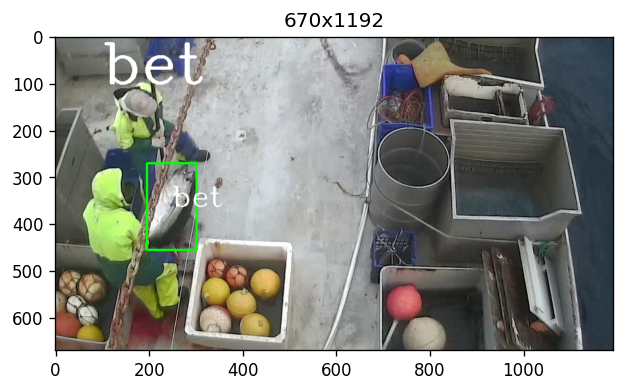

In [0]:
plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(boxes['bet'][17])
plt.imshow(img)
plt.title('{}x{}'.format(*img.shape));

# Сетка якорей (anchor grid)

In [0]:
feature_tensor = train_model.layers[-1].output
feature_tensor.shape

TensorShape([None, 23, 37, 11])

In [0]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [0]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], NUM_CLASSES+4), dtype=np.float32)
    
    # #adding 1 to No Fish column
    # nof_idx = np.argmax(enc.transform([['nof']])[0])
    # encoded[..., nof_idx] = 1

    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            #modified to add OH encodings
            # if np.sum(annotation['OH_label'][0]) < 0.1: #no fish in anchor
            #     anc_label = enc.transform([['nof']])[0]
            # else:
            #     anc_label = annotation['OH_label'][0]
            encoded[row, col] = np.hstack((annotation['OH_label'][0], dx, dy, dw, dh)) #12 values
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.25):
    rectangles = []
    
    #Excluding NoF
    # nof_idx = np.argmax(enc.transform([['nof']])[0])

    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logits =  prediction[row, col][:NUM_CLASSES]
            dx, dy, dw, dh = prediction[row, col][NUM_CLASSES:]
            conf_vec = _sigmoid(logits)
            conf = np.max(conf_vec)
            #zero NoF field
            # conf[nof_idx]=0

            if conf > conf_thr:
                # print(logits)
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'conf_vec': conf_vec})
    return rectangles

### Валидация енкодинга/декодинга

In [0]:
boxes['shark'][175]

{'OH_label': array([[0., 0., 0., 0., 0., 1., 0.]]),
 'annotations': [{'class': 'rect',
   'conf_vec': array([0., 0., 0., 0., 0., 1., 0.]),
   'height': 123.00000000000023,
   'width': 71.00000000000017,
   'x': 151.50000000000037,
   'y': 608.5000000000015},
  {'class': 'rect',
   'conf_vec': array([0., 0., 0., 0., 0., 1., 0.]),
   'height': 71.00000000000017,
   'width': 157.00000000000034,
   'x': 549.5000000000014,
   'y': 477.50000000000114}],
 'class': 'image',
 'filename': './train/SHARK/img_00033.jpg'}

In [0]:
example = boxes['shark'][175]

encoded = encode_anchors(example, (IMG_HEIGHT, IMG_WIDTH))
encoded[13][16]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        , -0.09576577, -0.24855073, -0.04666667,
        0.52666664], dtype=float32)

In [0]:
encoded[..., :7].shape

(23, 37, 7)

In [0]:
for i in range(encoded.shape[0]):
    for j in range(encoded.shape[1]):
        if np.sum(encoded[i][j]) > 0:
            print('%d : %d\n' % (i, j))

13 : 16

18 : 5



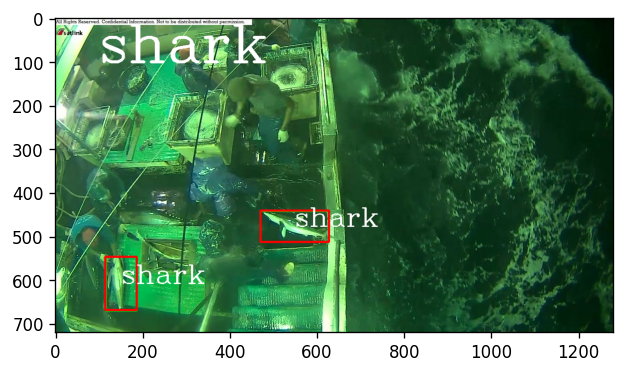

In [0]:
example = boxes['shark'][175]

encoded = encode_anchors(example, (IMG_HEIGHT, IMG_WIDTH))

decoded = decode_prediction(encoded, conf_thr=0.6)
decoded = sorted(decoded, key = lambda e: -np.max(e['conf']))

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(example, decoded[:10]))

In [0]:
decoded

[{'conf': 0.7310586,
  'conf_vec': array([0.5      , 0.5      , 0.5      , 0.5      , 0.5      , 0.7310586,
         0.5      ], dtype=float32),
  'height': 71.00000381469727,
  'width': 157.00000002980232,
  'x': 549.500000557384,
  'y': 477.50000049886495},
 {'conf': 0.7310586,
  'conf_vec': array([0.5      , 0.5      , 0.5      , 0.5      , 0.5      , 0.7310586,
         0.5      ], dtype=float32),
  'height': 122.9999989271164,
  'width': 71.00000381469727,
  'x': 151.49999983810093,
  'y': 608.4999999355364}]

## Функция потерь

In [0]:
K = tf.keras.backend

In [0]:
def sum_el_mult(a, b):
    #Multiply a * b element-wise & sum through layers
    res = tf.zeros_like(a)

    for i in range(b.shape[-1]):
        res += keras.layers.multiply((a, b[..., i]))

    return res

def confidence_loss(y_true, y_pred):
    #modified for classification
    sigm_pred = K.sigmoid(y_pred[..., :NUM_CLASSES])
    # softmax = K.softmax(y_pred[..., :NUM_CLASSES])
    conf_loss = K.sum(K.binary_crossentropy(y_true[..., :NUM_CLASSES], 
                                             sigm_pred,from_logits=False), axis=-1)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., NUM_CLASSES:] - y_pred[..., NUM_CLASSES:])
    square_loss = 0.5 * K.square(y_true[..., NUM_CLASSES:] - y_pred[..., NUM_CLASSES:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    # TODO: добавьте функцию потерь для классификации детекции
    
    y_true = K.reshape(y_true, (batch_size, -1, NUM_CLASSES+4))
    y_pred = K.reshape(y_pred, (batch_size, -1, NUM_CLASSES+4))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = sum_el_mult(conf_loss, tf.convert_to_tensor(y_true[..., :NUM_CLASSES]))
    pos_loc_loss = sum_el_mult(loc_loss, tf.convert_to_tensor(y_true[..., :NUM_CLASSES]))
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., :NUM_CLASSES], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(sum_el_mult(conf_loss, tf.convert_to_tensor(1. - y_true[..., :NUM_CLASSES])),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss)
    pos_conf_loss = K.sum(pos_conf_loss)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)

    loc_loss = K.sum(loc_loss)
    
    return total_conf_loss + 0.5 * loc_loss

# def total_loss(y_true, y_pred, neg_pos_ratio=3):
#     batch_size = K.shape(y_true)[0]
    
#     # TODO: добавьте функцию потерь для классификации детекции
    
#     y_true = K.reshape(y_true, (batch_size, -1, NUM_CLASSES+4))
#     y_pred = K.reshape(y_pred, (batch_size, -1, NUM_CLASSES+4))

#     # confidence loss
#     conf_loss = confidence_loss(y_true, y_pred)
    
#     # smooth l1 loss
#     loc_loss = smooth_l1(y_true, y_pred)

#     return conf_loss + 0.5 * loc_loss

In [0]:
def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, keras.applications.vgg16.preprocess_input(img_resized.astype(np.float32))

#FUnction to load from preprocessed dat file
DAT_SHAPE = (46, 75, 512) #Shape of tensors
def load_dat(img_path, dat_path, dat_shape=DAT_SHAPE):
    img_shape = cv2.imread(img_path, cv2.IMREAD_COLOR)[...,::-1].shape
    # img_shape = img.shape
    dat = np.fromfile(dat_path, dtype=np.float32).reshape(dat_shape)
    return img_shape, dat

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        random.shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                # img_shape, img = load_dat(boxes[j]['filename'], boxes[j]['filename_dat'])
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                y.append(encode_anchors(boxes[j], img_shape))
                X.append(img)
            yield np.array(X), np.array(y)

## Обучение

In [0]:
adam = keras.optimizers.Adam(lr=3e-4, decay=1e-6)
train_model.compile( optimizer=adam, 
              loss=total_loss,
              metrics={'conv2d': confidence_loss})

In [0]:
# %xmode Verbose

batch_size =16
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

gen = data_generator(boxes, batch_size=batch_size)

checkpoint = keras.callbacks.ModelCheckpoint(
    'weights.{epoch:02d}-{loss:.3f}.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto', period=1)

train_model.fit_generator(generator=gen, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    callbacks=[checkpoint])

Epoch 1/10
189/188 [==============================] - ETA: 0s - loss: 773.9461 - confidence_loss: 4.3015
Epoch 00001: loss improved from inf to 773.94611, saving model to weights.01-773.946.hdf5
189/188 [==============================] - 193s 1s/step - loss: 773.9461 - confidence_loss: 4.3015
Epoch 2/10
189/188 [==============================] - ETA: 0s - loss: 389.8012 - confidence_loss: 2.5915
Epoch 00002: loss improved from 773.94611 to 389.80121, saving model to weights.02-389.801.hdf5
189/188 [==============================] - 190s 1s/step - loss: 389.8012 - confidence_loss: 2.5915
Epoch 3/10
189/188 [==============================] - ETA: 0s - loss: 255.6212 - confidence_loss: 1.4857
Epoch 00003: loss improved from 389.80121 to 255.62122, saving model to weights.03-255.621.hdf5
189/188 [==============================] - 191s 1s/step - loss: 255.6212 - confidence_loss: 1.4857
Epoch 4/10
189/188 [==============================] - ETA: 0s - loss: 194.6472 - confidence_loss: 0.9620
E

In [0]:
#copy to G drive
!cp *.hdf5 '/content/drive/My Drive/fish/'

cp: cannot stat '*.hdf5': No such file or directory


In [0]:
!cp '/content/drive/My Drive/fish/weights.10-120.386.hdf5' ./

In [0]:
train_model.load_weights('./weights.10-120.386.hdf5')

In [0]:
train_model.summary()

Model: "trainable_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 750, 1200, 3)]    0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 750, 1200, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 750, 1200, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 375, 600, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 375, 600, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 375, 600, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 187, 300, 128) 

In [0]:
batch_size = 16
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

gen = data_generator(boxes, batch_size=batch_size)

checkpoint = keras.callbacks.ModelCheckpoint(
    'weights.run2.{epoch:02d}-{loss:.3f}.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto', period=1)

train_model.fit_generator(generator=gen, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=20,
                    callbacks=[checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
189/188 [==============================] - ETA: -2s - loss: 133.1649 - confidence_loss: 0.3928
Epoch 00001: loss improved from inf to 133.16492, saving model to weights.run2.01-133.165.hdf5
189/188 [==============================] - 678s 4s/step - loss: 133.1649 - confidence_loss: 0.3928
Epoch 2/20
189/188 [==============================] - ETA: -2s - loss: 122.3393 - confidence_loss: 0.3545
Epoch 00002: loss improved from 133.16492 to 122.33931, saving model to weights.run2.02-122.339.hdf5
189/188 [==============================] - 681s 4s/step - loss: 122.3393 - confidence_loss: 0.3545
Epoch 3/20
189/188 [==============================] - ETA: -2s - loss: 114.5649 - confidence_loss: 0.3173
Epoch 00003: loss improved from 122.33931 to 114.56486, saving model to weights.run2.03-114.565.hdf5
189/188 [==============================] - 681s 4s/step - loss: 114.5649 - confidence_loss: 0.3173
Epoch 4/20
1

In [0]:
#copy to G drive
!cp *.hdf5 '/content/drive/My Drive/fish/'

In [0]:
#Loading weights
# !cp '/content/drive/My Drive/fish/weights.run2.19-47.364.hdf5' ./
train_model.load_weights('/content/drive/My Drive/fish/weights.run2.19-47.364.hdf5')

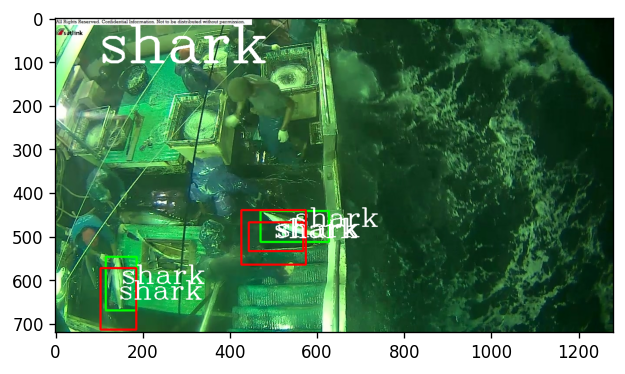

In [0]:
example = boxes['shark'][175]
img_shape, img = load_img(example['filename'])
# _, img_dat = load_img(example['filename'], exam)

pred = train_model.predict(np.array([img]))[0]

encoded = encode_anchors(example, (IMG_HEIGHT, IMG_WIDTH))
decoded = decode_prediction(pred, conf_thr=0.3)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(example, decoded))

In [0]:
other_pics = ['./train/OTHER/img_01807.jpg',
              './train/OTHER/img_03572.jpg',
              './train/OTHER/img_05133.jpg',
              './train/OTHER/img_00397.jpg',
              './train/OTHER/img_02202.jpg',
              './train/OTHER/img_07077.jpg']

<Figure size 1152x1152 with 0 Axes>

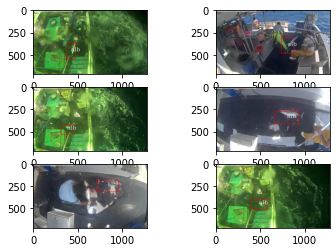

In [0]:
plt.figure(figsize=(16, 16))#, dpi=120)
plt.subplots(nrows=3, ncols=2)

for i in range(len(other_pics)):
    img_shape, img = load_img(other_pics[i])
    # _, img_dat = load_img(example['filename'], exam)

    pred = train_model.predict(np.array([img]))[0]

    # encoded = encode_anchors(example, (IMG_HEIGHT, IMG_WIDTH))
    decoded = decode_prediction(pred, conf_thr=0.01)
    decoded = sorted(decoded, key=lambda x: x['conf'], reverse=True)

    plt.subplot(3, 2, i+1)
    plt.imshow(draw_boxes_from_file(other_pics[i], decoded[:1]))

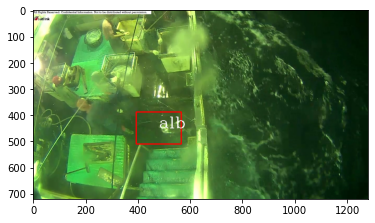

In [0]:
path = other_pics[5]
img_shape, img = load_img(path)
# _, img_dat = load_img(example['filename'], exam)

pred = train_model.predict(np.array([img]))[0]

# encoded = encode_anchors(example, (IMG_HEIGHT, IMG_WIDTH))
decoded = decode_prediction(pred, conf_thr=0.01)
decoded = sorted(decoded, key=lambda x: x['conf'], reverse=True)

# plt.subplot(3, 2, i+1)
plt.imshow(draw_boxes_from_file(path, decoded[:1]))

In [0]:
boxes['lag'][0]

{'OH_label': array([[0., 0., 0., 1., 0., 0., 0.]]),
 'annotations': [{'class': 'rect',
   'conf_vec': array([0., 0., 0., 1., 0., 0., 0.]),
   'height': 308.0000000000008,
   'width': 398.0000000000009,
   'x': 790.0000000000019,
   'y': 325.0000000000008},
  {'class': 'rect',
   'conf_vec': array([0., 0., 0., 1., 0., 0., 0.]),
   'height': 224.0000000000005,
   'width': 366.0000000000008,
   'x': 861.000000000002,
   'y': 607.0000000000015}],
 'class': 'image',
 'filename': './train/LAG/img_07919.jpg'}

In [0]:
decoded[0]['conf_vec'] = np.array([1, 0, 0, 0, 0, 0, 0])
decoded[0]

{'conf': 0.0355358,
 'conf_vec': array([1, 0, 0, 0, 0, 0, 0]),
 'height': 122.34979346394539,
 'width': 172.72551655769348,
 'x': 480.4842018799202,
 'y': 449.4198341813424}

In [0]:
OH_label = enc.transform([['other']])
conf_vec = OH_label[0]
other_boxes = []

for path in tqdm.tqdm_notebook(glob('./train/OTHER/*')):
    # full_path = './train/OTHER/' + file

    img_shape, img = load_img(path)
    pred = train_model.predict(np.array([img]))[0]

    decoded = decode_prediction(pred, conf_thr=0.0)
    decoded = sorted(decoded, key=lambda x: x['conf'], reverse=True)    

    rect_dict = {'class': 'rect',
                'conf_vec': conf_vec,
                'height': decoded[0]['height'],
                'width': decoded[0]['width'],
                'x': decoded[0]['x'],
                'y': decoded[0]['y']}

    cur_box = {'OH_label': OH_label,
               'annotations': [rect_dict],
               'class': 'image',
               'filename': path}

    other_boxes.append(cur_box)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [0]:
other_boxes[0]

{'OH_label': array([[0., 0., 0., 0., 1., 0., 0.]]),
 'annotations': [{'class': 'rect',
   'conf_vec': array([0., 0., 0., 0., 1., 0., 0.]),
   'height': 94.85044330358505,
   'width': 181.26748502254486,
   'x': 446.26111251276893,
   'y': 483.9144731345384}],
 'class': 'image',
 'filename': './train/OTHER/img_04060.jpg'}

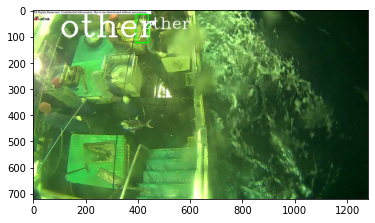

In [0]:
plt.imshow(draw_boxes(other_boxes[14]))

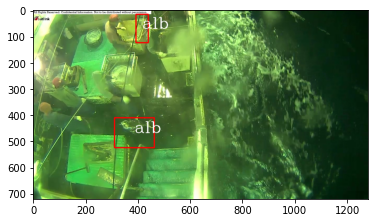

In [0]:
img_shape, img = load_img(other_boxes[14]['filename'])
pred = train_model.predict(np.array([img]))[0]

decoded = decode_prediction(pred, conf_thr=0.0)
decoded = sorted(decoded, key=lambda x: x['conf'], reverse=True)

plt.imshow(draw_boxes_from_file(other_boxes[14]['filename'], decoded[:2]))